**Importing Libraries**

In [ ]:
#Import Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import SVG, Image
import tensorflow as tf

**Loading Dataset**

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Kaggel Competition/train.csv')

In [ ]:
train.head()

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

In [ ]:
train.emotion.value_counts(sort = True)

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Here we can see that the dataset is imbalanced as the target doesn't have equal no. of records for all the categories

In [ ]:
train.pixels.shape

(28709,)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


**Visualizing the emotions in the dataset**

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

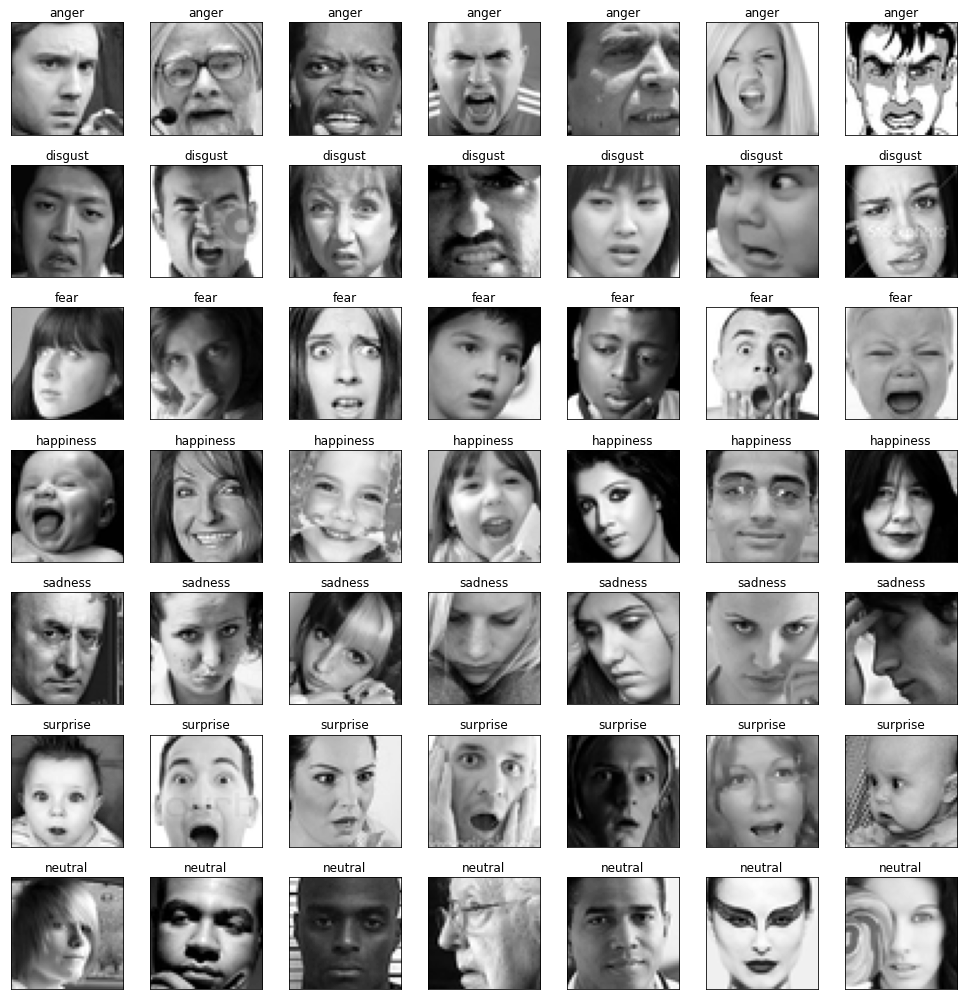

In [ ]:
from matplotlib import pyplot

fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(train.emotion.unique()):
    for j in range(7):
        px = train[train.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('uint8')
        #px = px.split(' ') #pixels are separated by spaces.
        #px = np.asarray(px, dtype=np.uint8).reshape(48,48) #Convert list to array
        #'unit8' gives values between 0 to 255
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

Now making the data compatible for neural networks.
For that we will convert 1 dim array to 4 dim

In [ ]:
#To split the the sequence of numbers and then store them in a array
#then reshape to (48,48,1) having type 'uint8'i.e values between 0 to 255
img_array = train.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48,1).astype('uint8'))
print(img_array.ndim)
print(img_array.shape)
#Join a sequence of arrays along a new axis. The axis parameter specifies the index of the new axis
#in the dimensions of the result. For example, if axis=0 it will be the first dimension
#img_array=img_array.reshape(len,48,48,1)
img_array = np.stack(img_array, axis=0)
print(img_array.ndim)
print(img_array.shape)

1
(28709,)
4
(28709, 48, 48, 1)


In [ ]:
print(img_array.shape)

(28709, 48, 48, 1)


**Performing label encoding on the emotion column**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
img_labels = le.fit_transform(train.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(28709, 7)

In [ ]:
img_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

**Splitting dataset into train and test**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                      test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((22967, 48, 48, 1), (5742, 48, 48, 1), (22967, 7), (5742, 7))

Earlier we saw that the dataset is imbalanced hence we use ImageDataGenerator to make it balanced.

In [ ]:
#Now we will scale the values between 0 to 1 i.e to get grayscale 
train_datagen = ImageDataGenerator(
					rescale=1./255,      # we multiply the data by the value provided 
					horizontal_flip=True)
train_datagen.fit(X_train)
#train_data = train_datagen.flow(X_train, y_train ,batch_size=25)

val_datagen = ImageDataGenerator(
					rescale=1./255,      # we multiply the data by the value provided 
					horizontal_flip=True)
val_datagen.fit(X_valid)
#val_data = val_datagen.flow(X_valid, y_valid ,batch_size=32)


In [ ]:
#Model Building

# Initialising the CNN
model = tf.keras.Sequential()

# 1 - Convolution
model.add(tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu',input_shape=(48, 48,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# 2nd Convolution layer
model.add(tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# 3rd Convolution layer
model.add(tf.keras.layers.Conv2D(512,(3,3), padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# 4th Convolution layer
model.add(tf.keras.layers.Conv2D(512,(3,3), padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# Flattening
model.add(tf.keras.layers.Flatten())

# Fully connected layer 1st layer
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

# Fully connected layer 2nd layer
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(7, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

You can use callbacks to:

*   Write TensorBoard logs after every batch of training to 
*   monitor your metrics
*   Periodically save your model to disk
*   Do early stopping
*   Get a view on internal states and statistics of a model during training








In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

#Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

callbacks = [checkpoint, reduce_lr]

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data = val_datagen.flow(X_valid, y_valid, batch_size=batch_size),
    callbacks=callbacks,
    )

Epoch 1/100
716/717 [============================>.] - ETA: 0s - loss: 1.9876 - accuracy: 0.2632
Epoch 00001: saving model to model_weights.h5
717/717 [==============================] - 27s 38ms/step - loss: 1.9873 - accuracy: 0.2633 - val_loss: 2.6514 - val_accuracy: 0.1877
Epoch 2/100
717/717 [==============================] - ETA: 0s - loss: 1.5855 - accuracy: 0.3933
Epoch 00002: saving model to model_weights.h5
717/717 [==============================] - 27s 37ms/step - loss: 1.5855 - accuracy: 0.3933 - val_loss: 1.7599 - val_accuracy: 0.3676
Epoch 3/100
717/717 [==============================] - ETA: 0s - loss: 1.3941 - accuracy: 0.4648
Epoch 00003: saving model to model_weights.h5
717/717 [==============================] - 26s 37ms/step - loss: 1.3941 - accuracy: 0.4648 - val_loss: 1.7814 - val_accuracy: 0.3020
Epoch 4/100
717/717 [==============================] - ETA: 0s - loss: 1.2835 - accuracy: 0.5088
Epoch 00004: saving model to model_weights.h5
717/717 [====================

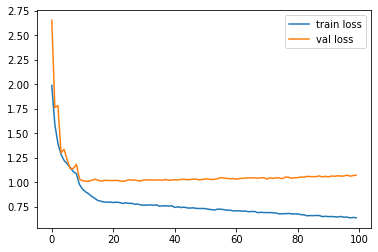

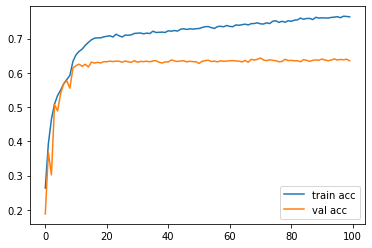

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Accuracy')


Here we can see that the train_accuracy increases more tha 75% after 50 epochs. The validation_accuracy also shows some improvement initially (little more than 60%) but after 20 epochs remains almost constant.

In [ ]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# **Using the model to detect my face emotions through webcam**

<IPython.core.display.Javascript object>

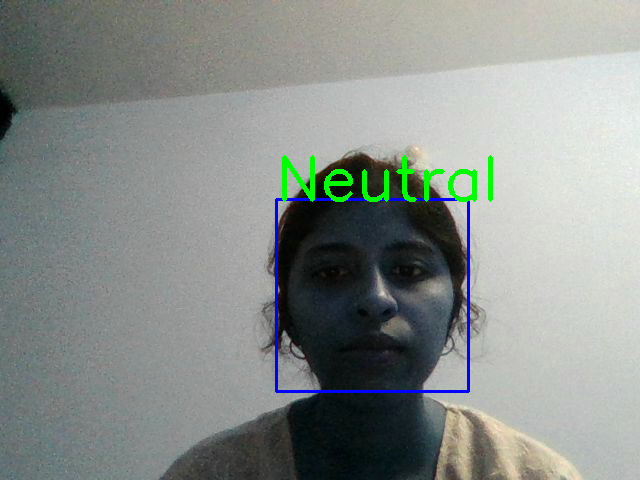

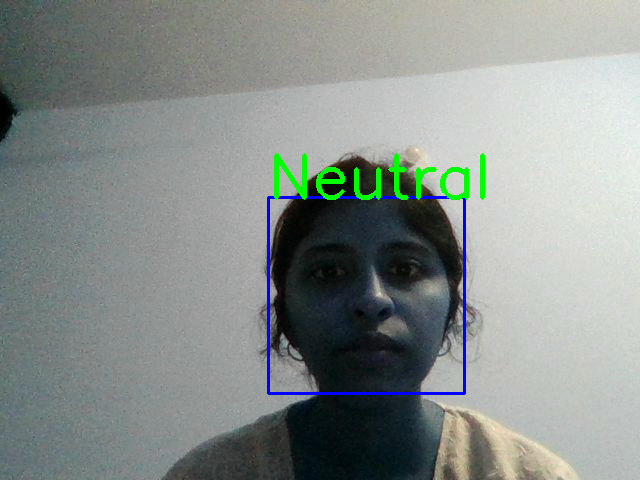

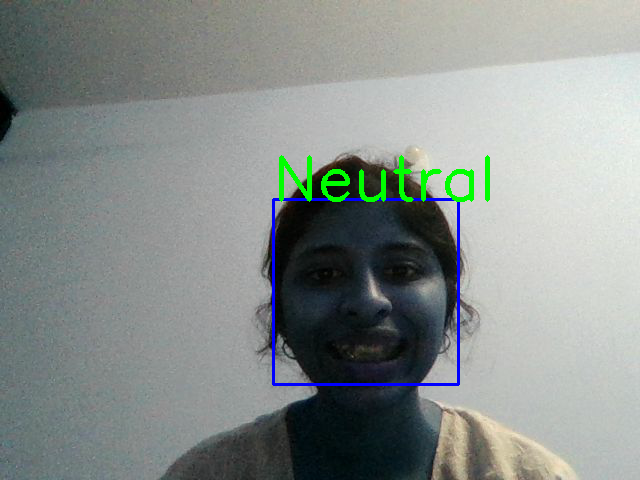

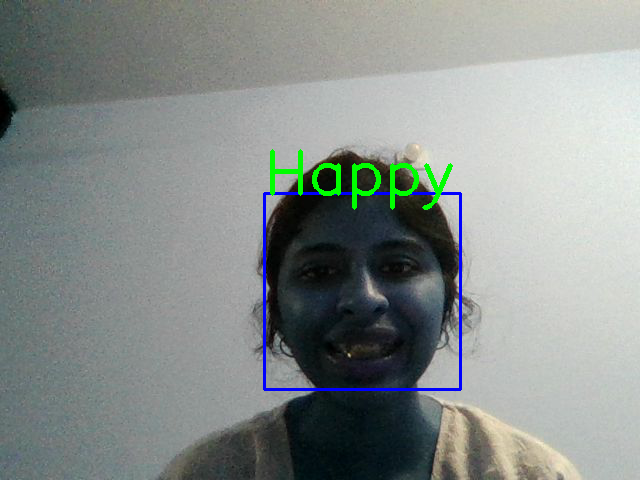

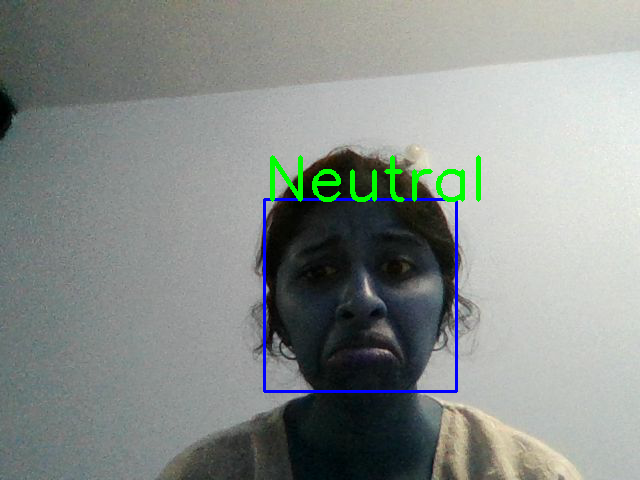

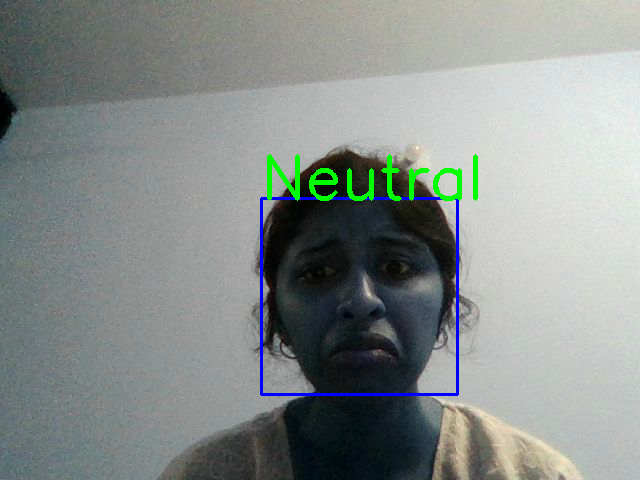

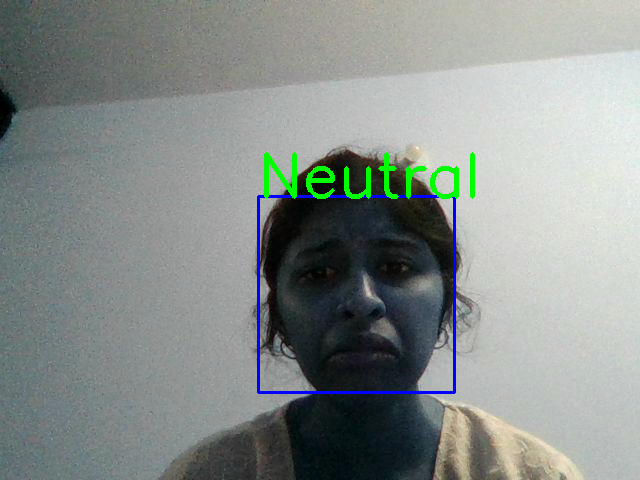

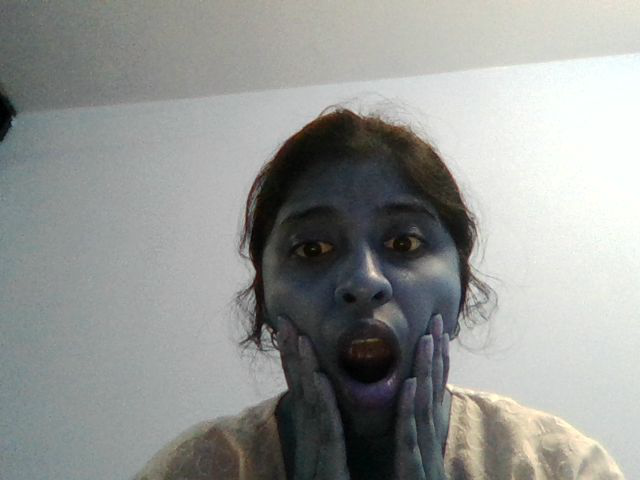

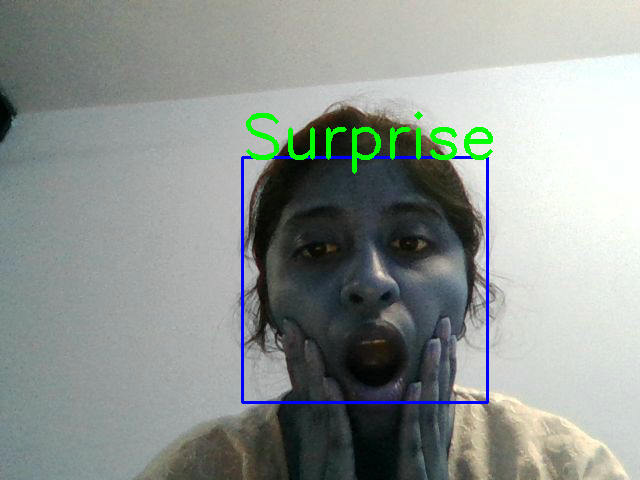

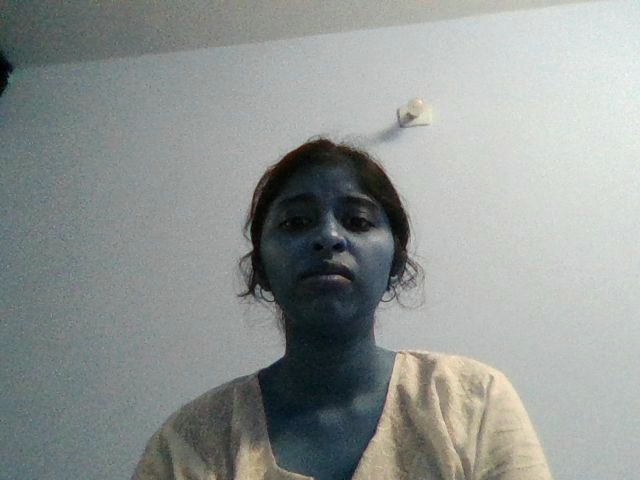

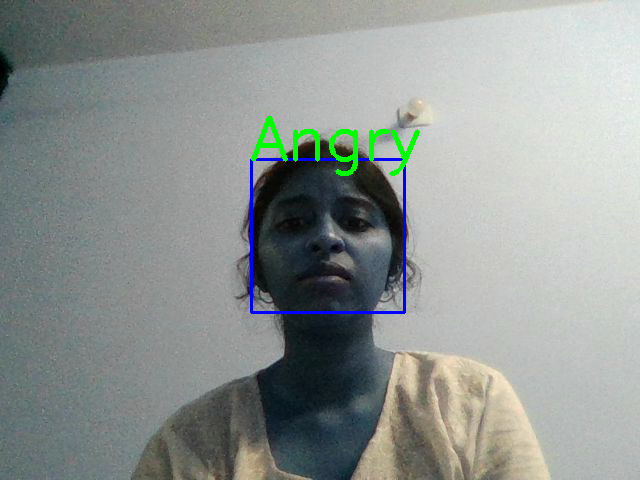

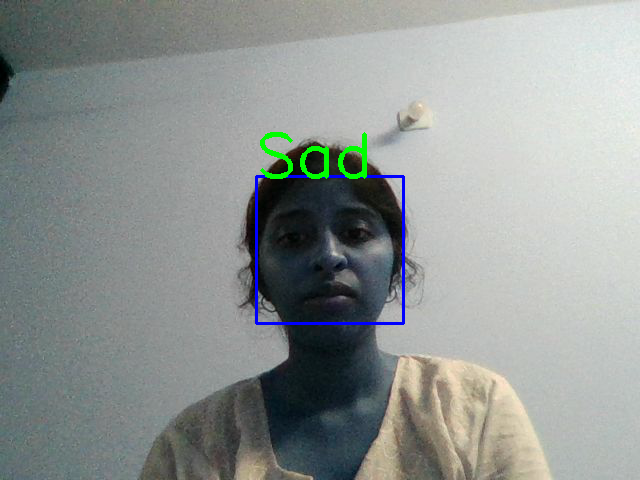

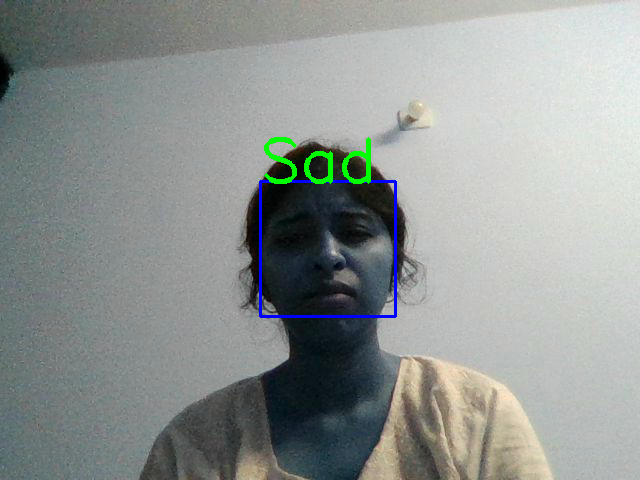

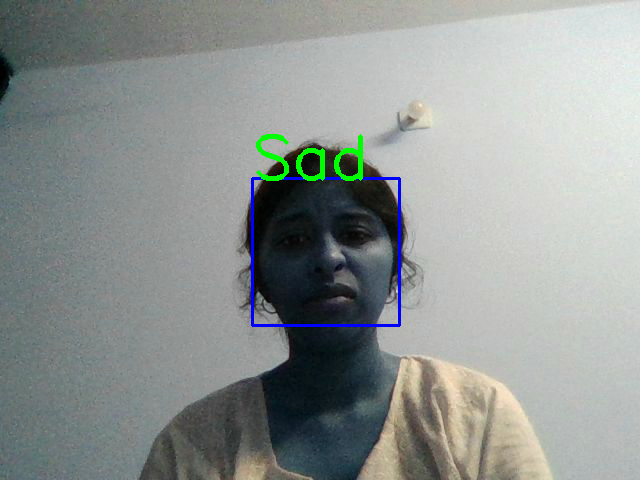

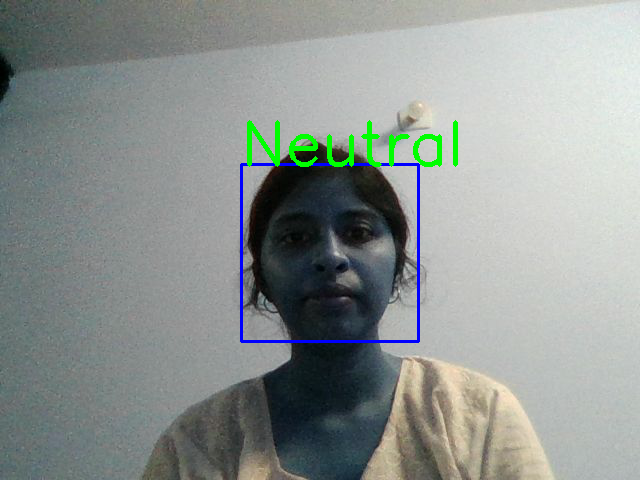

In [ ]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
from google.colab.patches import cv2_imshow

#This function helps to acces the webcam in google colab to video stream my face.
#As cv2.CaptureVideo() wasn't working in colab I used this function
def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

VideoCapture()
eval_js('create()')

face_classifier = cv2.CascadeClassifier(r'/content/drive/My Drive/Kaggel Competition/Face Recognition/haarcascade_frontalface_default.xml')
classifier =load_model(r'/content/model.h5')
#{0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
class_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

count = 0
while True:
    count += 1
    # Grab a single frame of video
    byte = eval_js('capture()')
    im = byte2image(byte)
    labels = []
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray,1.3,5)

    #To draw a rectangle round the face when the face is detected
    for (x,y,w,h) in faces:
        cv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)
    
        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

        # make a prediction on the ROI, then lookup the class
            preds = classifier.predict(roi)[0]
            label = class_labels[preds.argmax()]
            label_position = (x,y)
            cv2.putText(im,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        else:
            cv2.putText(im,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    cv2_imshow(im)
    if count == 15:
        break


#cap.release()
#cv2.destroyAllWindows()

We can see here that whenever my face was detected picture was captured from the webcam.

Still the model has to improve as we can see that it couldn't detect some emotions properly